In [1]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import util

from args import get_test_args
from collections import OrderedDict
from json import dumps
from models import BiDAF,BiDAFDT
from os.path import join
#from tensorboardX import SummaryWriter
from tqdm import tqdm
from ujson import load as json_load
from util import collate_fn, SQuAD

import spacy
import numpy as np
from collections import Counter


In [2]:

# model_path = 'save/train/bidaf-01/best.pth.tar'
model_path = 'save/train/dt-04/best.pth.tar'

word2idx_path = 'data/word2idx.json'

# python test.py --split SPLIT --load_path PATH --name NAME
# python test.py --split dev --load_path save/train/baseline-01/step_50048.pth.tar --name first

In [3]:
# arguments: get_train_args

import argparse
from args import add_common_args, add_train_test_args

parser = argparse.ArgumentParser('Test a trained model on SQuAD')

add_common_args(parser)
add_train_test_args(parser)


parser.add_argument('--eval_steps',
                    type=int,
                    default=50000,
                    help='Number of steps between successive evaluations.')
parser.add_argument('--lr',
                    type=float,
                    default=0.5,
                    help='Learning rate.')
parser.add_argument('--l2_wd',
                    type=float,
                    default=0,
                    help='L2 weight decay.')
parser.add_argument('--num_epochs',
                    type=int,
                    default=30,
                    help='Number of epochs for which to train. Negative means forever.')
parser.add_argument('--drop_prob',
                    type=float,
                    default=0.2,
                    help='Probability of zeroing an activation in dropout layers.')
parser.add_argument('--metric_name',
                    type=str,
                    default='F1',
                    choices=('NLL', 'EM', 'F1'),
                    help='Name of dev metric to determine best checkpoint.')
parser.add_argument('--max_checkpoints',
                    type=int,
                    default=5,
                    help='Maximum number of checkpoints to keep on disk.')
parser.add_argument('--max_grad_norm',
                    type=float,
                    default=5.0,
                    help='Maximum gradient norm for gradient clipping.')
parser.add_argument('--seed',
                    type=int,
                    default=224,
                    help='Random seed for reproducibility.')
parser.add_argument('--ema_decay',
                    type=float,
                    default=0.999,
                    help='Decay rate for exponential moving average of parameters.')


params = f'--load_path {model_path} --name dt --use_squad_v2 False'.split()
args = parser.parse_args(params)

In [4]:
import json

# Set up logging
args.save_dir = util.get_save_dir(args.save_dir, args.name, training=False)
log = util.get_logger(args.save_dir, args.name)
device, gpu_ids = util.get_available_devices()

args.batch_size = 16
args.batch_size *= max(1, len(gpu_ids))
log.info(f'Args: {dumps(vars(args), indent=4, sort_keys=True)}')


# word to id dictionary
word2idx_dict = json.load(open(word2idx_path))

# Get embeddings
log.info('Loading embeddings...')
word_vectors = util.torch_from_json(args.word_emb_file)

[11.01.21 00:28:29] Args: {
    "batch_size": 16,
    "char_emb_file": "./data/char_emb.json",
    "dev_eval_file": "./data/dev_eval.json",
    "dev_record_file": "./data/dev.npz",
    "drop_prob": 0.2,
    "ema_decay": 0.999,
    "eval_steps": 50000,
    "hidden_size": 100,
    "l2_wd": 0,
    "load_path": "save/train/dt-04/best.pth.tar",
    "lr": 0.5,
    "max_ans_len": 15,
    "max_checkpoints": 5,
    "max_grad_norm": 5.0,
    "metric_name": "F1",
    "name": "dt",
    "num_epochs": 30,
    "num_visuals": 10,
    "num_workers": 4,
    "save_dir": "./save/test/dt-02",
    "seed": 224,
    "test_eval_file": "./data/test_eval.json",
    "test_record_file": "./data/test.npz",
    "train_eval_file": "./data/train_eval.json",
    "train_record_file": "./data/train.npz",
    "use_squad_v2": false,
    "word_emb_file": "./data/word_emb.json"
}
[11.01.21 00:28:29] Loading embeddings...


In [5]:
%%time

# Get data loader
log.info('Building dataset...')
train_dataset = SQuAD(args.train_record_file, args.use_squad_v2)
train_loader = data.DataLoader(train_dataset,
                               batch_size=args.batch_size,
                               shuffle=True,
                               num_workers=args.num_workers,
                               collate_fn=collate_fn)
dev_dataset = SQuAD(args.dev_record_file, args.use_squad_v2)
dev_loader = data.DataLoader(dev_dataset,
                             batch_size=args.batch_size,
                             shuffle=False,
                             num_workers=args.num_workers,
                             collate_fn=collate_fn)

[11.01.21 00:28:35] Building dataset...
CPU times: user 7.41 s, sys: 6.46 s, total: 13.9 s
Wall time: 13.9 s


In [6]:
# define model

import layers
import torch
import torch.nn as nn

class BiDAFDT(nn.Module):
    """Baseline BiDAF model for SQuAD.

    Based on the paper:
    "Bidirectional Attention Flow for Machine Comprehension"
    by Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi, Hannaneh Hajishirzi
    (https://arxiv.org/abs/1611.01603).

    Follows a high-level structure commonly found in SQuAD models:
        - Embedding layer: Embed word indices to get word vectors.
        - Encoder layer: Encode the embedded sequence.
        - Attention layer: Apply an attention mechanism to the encoded sequence.
        - Model encoder layer: Encode the sequence again.
        - Output layer: Simple layer (e.g., fc + softmax) to get final outputs.

    Args:
        word_vectors (torch.Tensor): Pre-trained word vectors.
        hidden_size (int): Number of features in the hidden state at each layer.
        drop_prob (float): Dropout probability.
    """
    def __init__(self, word_vectors, hidden_size, drop_prob=0., train_mode=False):
        super(BiDAFDT, self).__init__()
        
        self.hidden_size = hidden_size
        self.drop_prob = drop_prob
        
        self.train_mode = train_mode
        
        self.emb = layers.Embedding(word_vectors=word_vectors,
                                    hidden_size=hidden_size,
                                    drop_prob=drop_prob)

        self.enc = layers.RNNEncoder(input_size=hidden_size,
                                     hidden_size=hidden_size,
                                     num_layers=1,
                                     drop_prob=drop_prob)

        self.att = layers.BiDAFAttention(hidden_size=2 * hidden_size,
                                         drop_prob=drop_prob)

        self.mod = layers.RNNEncoder(input_size=8 * hidden_size,
                                     hidden_size=hidden_size,
                                     num_layers=2,
                                     drop_prob=drop_prob)
        
        self.dt = layers.RNNEncoder(input_size=2*hidden_size,
                                     hidden_size=hidden_size,
                                     num_layers=2,
                                     drop_prob=drop_prob)

    
        self.out = layers.BiDAFOutput(hidden_size=hidden_size,
                                      drop_prob=drop_prob)


    def forward(self, cw_idxs, qw_idxs, iters_to_do=1):
        c_mask = torch.zeros_like(cw_idxs) != cw_idxs
        q_mask = torch.zeros_like(qw_idxs) != qw_idxs
        c_len, q_len = c_mask.sum(-1), q_mask.sum(-1)

        c_emb = self.emb(cw_idxs)         # (batch_size, c_len, hidden_size)
        q_emb = self.emb(qw_idxs)         # (batch_size, q_len, hidden_size)

        c_enc = self.enc(c_emb, c_len)    # (batch_size, c_len, 2 * hidden_size)
        q_enc = self.enc(q_emb, q_len)    # (batch_size, q_len, 2 * hidden_size)
        # add DT here?

        att = self.att(c_enc, q_enc,
                       c_mask, q_mask)    # (batch_size, c_len, 8 * hidden_size)

        mod = self.mod(att, c_len)        # (batch_size, c_len, 2 * hidden_size)
        
#         # add DT here?
#         interim_thought = mod.to(device)
        interim_thought = mod

        # all_outputs = torch.zeros((x.size(0), iters_to_do, 2, x.size(2))).to(x.device)
        interim_thoughts = []
        
        for i in range(iters_to_do):
            # if self.recall:
            #     interim_thought = torch.cat([interim_thought, x], 1)
                # in: 800
#             print(interim_thought.shape, c_len.shape)
            interim_thought = self.dt(interim_thought, c_len)
#             interim_thought = self.recur_block(interim_thought)
#             out = self.head(interim_thought)
        # all_outputs[:, i] = out
            if not self.train_mode:
                interim_thoughts.append(interim_thought)

#         mod = interim_thought
        out = self.out(att, mod, c_mask)  # 2 tensors, each (batch_size, c_len)
#         # add DT here?
        
        if self.train_mode:
            return out
        else:
            # run outputs thru head
            all_outputs = []
            for thought in interim_thoughts:
                all_outputs.append(self.out(att, thought, c_mask))
            return all_outputs
    
# Get model
log.info('Building model...')
model = BiDAFDT(word_vectors=word_vectors,
              hidden_size=args.hidden_size,
               train_mode=False)
model = nn.DataParallel(model, gpu_ids)


log.info(f'Loading checkpoint from {args.load_path}...')
model = util.load_model(model, args.load_path, gpu_ids, return_step=False)

model = model.to(device)
model.eval()

[11.01.21 00:28:48] Building model...
[11.01.21 00:28:51] Loading checkpoint from save/train/dt-04/best.pth.tar...


DataParallel(
  (module): BiDAFDT(
    (emb): Embedding(
      (embed): Embedding(88714, 300)
      (proj): Linear(in_features=300, out_features=100, bias=False)
      (hwy): HighwayEncoder(
        (transforms): ModuleList(
          (0): Linear(in_features=100, out_features=100, bias=True)
          (1): Linear(in_features=100, out_features=100, bias=True)
        )
        (gates): ModuleList(
          (0): Linear(in_features=100, out_features=100, bias=True)
          (1): Linear(in_features=100, out_features=100, bias=True)
        )
      )
    )
    (enc): RNNEncoder(
      (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
    )
    (att): BiDAFAttention()
    (mod): RNNEncoder(
      (rnn): LSTM(800, 100, num_layers=2, batch_first=True, bidirectional=True)
    )
    (dt): RNNEncoder(
      (rnn): LSTM(200, 100, num_layers=2, batch_first=True, bidirectional=True)
    )
    (out): BiDAFOutput(
      (att_linear_1): Linear(in_features=800, out_features=1, bias=True)
   

In [7]:
# Get optimizer and scheduler

import torch.optim as optim
import torch.optim.lr_scheduler as sched

optimizer = optim.Adadelta(model.parameters(), args.lr,
                           weight_decay=args.l2_wd)
scheduler = sched.LambdaLR(optimizer, lambda s: 1.)  # Constant LR


In [8]:
# # train

# step = 0
# args.num_epochs = 5

# # Train
# log.info('Training...')
# #     steps_till_eval = args.eval_steps
# epoch = step // len(train_dataset)
# while epoch != args.num_epochs:
#     epoch += 1
#     log.info(f'Starting epoch {epoch}...')
#     with torch.enable_grad(), \
#             tqdm(total=len(train_loader.dataset)) as progress_bar:
#         for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in train_loader:
#             # Setup for forward
#             cw_idxs = cw_idxs.to(device)
#             qw_idxs = qw_idxs.to(device)
#             batch_size = cw_idxs.size(0)
#             optimizer.zero_grad()

#             # Forward
# #             log_p1, log_p2 = model(cw_idxs, qw_idxs)
# #             y1, y2 = y1.to(device), y2.to(device)
# #             loss = F.nll_loss(log_p1, y1) + F.nll_loss(log_p2, y2)
# #             loss_val = loss.item()

#             thoughts = model(cw_idxs, qw_idxs, iters_to_do=10)
    
#             print(len(thoughts))


#             break

#     break


In [9]:
# evaluate

from collections import defaultdict

def evaluate(model, data_loader, device, eval_file, max_len, use_squad_v2, iterations):
    
    max_iters = max(iterations)
    
    nll_meter = util.AverageMeter()

    model.eval()
#     pred_dict = {}
    predictions_by_iterations = defaultdict(dict)
    with open(eval_file, 'r') as fh:
        gold_dict = json_load(fh)
        
    i = 0
    with torch.no_grad(), \
            tqdm(total=len(data_loader.dataset)) as progress_bar:
        for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in data_loader:
            # Setup for forward
            cw_idxs = cw_idxs.to(device)
            qw_idxs = qw_idxs.to(device)
            batch_size = cw_idxs.size(0)

            # Forward
#             log_p1, log_p2 = model(cw_idxs, qw_idxs)
            all_output = model(cw_idxs, qw_idxs, max_iters)
            for iters in range(max_iters):
                log_p1, log_p2 = all_output[iters]
            
                y1, y2 = y1.to(device), y2.to(device)
                loss = F.nll_loss(log_p1, y1) + F.nll_loss(log_p2, y2)
                nll_meter.update(loss.item(), batch_size)

                # Get F1 and EM scores
                p1, p2 = log_p1.exp(), log_p2.exp()
                starts, ends = util.discretize(p1, p2, max_len, use_squad_v2)


                preds, _ = util.convert_tokens(gold_dict,
                                               ids.tolist(),
                                               starts.tolist(),
                                               ends.tolist(),
                                               use_squad_v2)
#                 pred_dict.update(preds)
                if iters in iterations:
                    predictions_by_iterations[iters].update(preds)
            
            # Log info
            progress_bar.update(batch_size)
            progress_bar.set_postfix(NLL=nll_meter.avg)

#             print(predictions_by_iterations[1] == predictions_by_iterations[5])
#             print(predictions_by_iterations[1] == predictions_by_iterations[10])

#             break
            i += 1
            if i > 50:
                break
            
    model.train()
    
    # get results for each iteration
    
    results_by_iteration = {}
    for iters,pred_dict in predictions_by_iterations.items():
        
        results = util.eval_dicts(gold_dict, pred_dict, use_squad_v2)
        results_list = [('NLL', nll_meter.avg),
                        ('F1', results['F1']),
                        ('EM', results['EM'])]
        if use_squad_v2:
            results_list.append(('AvNA', results['AvNA']))
        results = OrderedDict(results_list)

#         return results, pred_dict
        results_by_iteration[iters] = results
    return results_by_iteration, predictions_by_iterations


# Evaluate and save checkpoint
# log.info(f'Evaluating at step {step}...')
# ema.assign(model)
iterations = [1,2,3,4,5,10,20,21]
results, pred_dict = evaluate(model, dev_loader, device,
                              args.dev_eval_file,
                              args.max_ans_len,
                              args.use_squad_v2,
                             iterations)

results
# saver.save(step, model, results[args.metric_name], device)
# ema.resume(model)

 29%|██▊       | 816/2848 [00:27<01:07, 30.00it/s, NLL=6.87]


{1: OrderedDict([('NLL', 6.8717976070585705),
              ('F1', 22.287655333235634),
              ('EM', 15.441176470588236)]),
 2: OrderedDict([('NLL', 6.8717976070585705),
              ('F1', 23.98113240355094),
              ('EM', 16.666666666666668)]),
 3: OrderedDict([('NLL', 6.8717976070585705),
              ('F1', 23.613485344727412),
              ('EM', 16.29901960784314)]),
 4: OrderedDict([('NLL', 6.8717976070585705),
              ('F1', 23.613485344727412),
              ('EM', 16.29901960784314)]),
 5: OrderedDict([('NLL', 6.8717976070585705),
              ('F1', 23.613485344727412),
              ('EM', 16.29901960784314)]),
 10: OrderedDict([('NLL', 6.8717976070585705),
              ('F1', 23.613485344727412),
              ('EM', 16.29901960784314)]),
 20: OrderedDict([('NLL', 6.8717976070585705),
              ('F1', 23.613485344727412),
              ('EM', 16.29901960784314)])}

<AxesSubplot:>

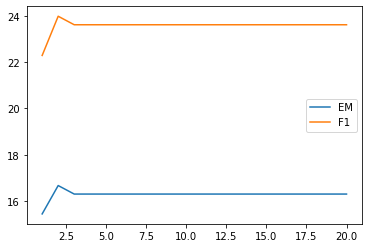

In [10]:
import pandas as pd

df = pd.DataFrame.from_dict(results, orient='index')
df.plot(y=['EM','F1'])

In [11]:
# debug
# def evaluate(model, data_loader, device, eval_file, max_len, use_squad_v2, iterations):
    
data_loader = test_loader
eval_file = args.test_eval_file
max_len = args.max_ans_len
use_squad_v2 = args.use_squad_v2
        
max_iters = max(iterations)

nll_meter = util.AverageMeter()

model.eval()
#     pred_dict = {}
predictions_by_iterations = defaultdict(dict)
with open(eval_file, 'r') as fh:
    gold_dict = json_load(fh)

i = 0
with torch.no_grad(), \
        tqdm(total=len(data_loader.dataset)) as progress_bar:
    for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in data_loader:
        # Setup for forward
        cw_idxs = cw_idxs.to(device)
        qw_idxs = qw_idxs.to(device)
        batch_size = cw_idxs.size(0)

        # Forward
#             log_p1, log_p2 = model(cw_idxs, qw_idxs)
        all_output = model(cw_idxs, qw_idxs, max_iters)
        for iters in range(max_iters):
            log_p1, log_p2 = all_output[iters]

            y1, y2 = y1.to(device), y2.to(device)
            loss = F.nll_loss(log_p1, y1) + F.nll_loss(log_p2, y2)
            nll_meter.update(loss.item(), batch_size)
        
        break

NameError: name 'test_loader' is not defined

In [ ]:
# preprocessing functions
# Import spacy language model

nlp = spacy.blank("en")

def word_tokenize(sent):
    doc = nlp(sent)
    return [token.text for token in doc]

def preprocess(context, question, word2idx_dict, is_test=False):
    
    context_tokens = word_tokenize(context)
    ques_tokens = word_tokenize(question)
    
#     para_limit = args.test_para_limit if is_test else args.para_limit
#     ques_limit = args.test_ques_limit if is_test else args.ques_limit

    para_limit = args.para_limit
    ques_limit = args.ques_limit
    ans_limit = args.ans_limit
    
    example = {'context_tokens': context_tokens, 'ques_tokens': ques_tokens}
    examples = [example]
    

#     print(f"Converting {data_type} examples to indices...")
    total = 0
    total_ = 0
    meta = {}
    context_idxs = []
    context_char_idxs = []
    ques_idxs = []
    ques_char_idxs = []
    y1s = []
    y2s = []
    ids = []
    for n, example in tqdm(enumerate(examples)):
        total_ += 1


        total += 1

        def _get_word(word):
            for each in (word, word.lower(), word.capitalize(), word.upper()):
                if each in word2idx_dict:
                    return word2idx_dict[each]
            return 1


        context_idx = np.zeros([para_limit], dtype=np.int32)
#         context_char_idx = np.zeros([para_limit, char_limit], dtype=np.int32)
        ques_idx = np.zeros([ques_limit], dtype=np.int32)
#         ques_char_idx = np.zeros([ques_limit, char_limit], dtype=np.int32)

        for i, token in enumerate(example["context_tokens"]):
            context_idx[i] = _get_word(token)
#         context_idxs.append(context_idx)

        for i, token in enumerate(example["ques_tokens"]):
            ques_idx[i] = _get_word(token)
#         ques_idxs.append(ques_idx)

        
        return context_idx, ques_idx
    
def merge_1d(arrays, dtype=torch.int64, pad_value=0):
        lengths = [(a != pad_value).sum() for a in arrays]
        padded = torch.zeros(len(arrays), max(lengths), dtype=dtype)
        for i, seq in enumerate(arrays):
            end = lengths[i]
            padded[i, :end] = seq[:end]
        return padded

In [ ]:
# answer custom questions

# context = '''Southern California, often abbreviated SoCal, is a geographic and cultural region that generally comprises California's southernmost 10 counties. The region is traditionally described as "eight counties", based on demographics and economic ties: Imperial, Los Angeles, Orange, Riverside, San Bernardino, San Diego, Santa Barbara, and Ventura. The more extensive 10-county definition, including Kern and San Luis Obispo counties, is also used based on historical political divisions. Southern California is a major economic center for the state of California and the United States.'''
# question = "What is Southern California often abbreviated as?"

# context = "The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (\"Norman\" comes from \"Norseman\") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries."
# question = "In what country is Normandy located?"

question = 'Who was an accountant?'
context = "Mary got off the flight to visit James."



# preprocess
# build_features(args, train_examples, "train", args.train_record_file, word2idx_dict, char2idx_dict)

def answer_question(context, question,always_answer=False):
    context_idxs, ques_idxs = preprocess(context, question, word2idx_dict)

    context_idxs = np.insert(context_idxs, 0, 1)
    ques_idxs = np.insert(ques_idxs, 0, 1)

    context_idxs = np.expand_dims(context_idxs, axis=0)
    ques_idxs = np.expand_dims(ques_idxs, axis=0)


    context_idxs = torch.from_numpy(context_idxs).long()
    ques_idxs = torch.from_numpy(ques_idxs).long()

    context_idxs = merge_1d(context_idxs)
    ques_idxs = merge_1d(ques_idxs)

    # ones = torch.ones((batch_size, 1), dtype=torch.int64)
    # self.context_idxs = torch.cat((ones, self.context_idxs), dim=1)
    # self.question_idxs = torch.cat((ones, self.question_idxs), dim=1)

#     context_idxs, ques_idxs
    
    # run model

#     print(context_idxs.shape, ques_idxs.shape)
    # context_idxs, ques_idxs = data_loader.dataset[0][0], data_loader.dataset[0][2]
    log_p1, log_p2 = model(context_idxs, ques_idxs)
#     print(log_p1.shape, log_p2.shape)
    p1, p2 = log_p1.exp(), log_p2.exp()
#     print(p1, p2, args.max_ans_len, args.use_squad_v2)

    starts_all = p1.argsort()
    ends_all = p2.argsort()
        
    starts, ends = util.discretize(p1, p2, args.max_ans_len, args.use_squad_v2)
    
    
    context_tokens = word_tokenize(context)
#     print(context_tokens[:10])

    start_idx, end_idx = starts.item(), ends.item()
    if (start_idx == 0 or end_idx == 0):
#         print("no answer")
        start = list(starts_all.detach().cpu().numpy())[0][-2]
        end = list(ends_all.detach().cpu().numpy())[0][-2]
        
        secondary_answer = context_tokens[start-1:end]
        
        if always_answer:
            return secondary_answer
        
        return 'no answer'
    
#     return ' '.join(context_tokens[start_idx-1:end_idx])
    return context_tokens[start_idx-1:end_idx]

In [ ]:
# analyze gender distro of ambig results
import json

ambig_retriever_path = '../../retrieval-based-baselines/ambig_retriever_results.json'

rtvr_results = json.load(open(ambig_retriever_path))
len(rtvr_results)

In [ ]:
print([t['title'] for t in rtvr_results[2]['ctxs']])

ctxs = rtvr_results[0]['ctxs']
len(ctxs)

In [ ]:
# # !pip install chicksexer

# from chicksexer import predict_gender
# # import chicksexer 


In [ ]:
# predict_gender('Saldivar Anderson')
# predict_gender('The Marine', return_proba=False)

In [ ]:
import gender_guesser.detector as gender
from collections import defaultdict

d = gender.Detector()

rtvr_passage_genders = defaultdict(int)
# rtvr_passage_genders = defaultdict(list)

for res in rtvr_results:
    res['genders'] = defaultdict(int)
#     res['genders'] = res['question']
    for ctx in res['ctxs']:
#         print(ctx['title'].split()[0])
        # filter out pages beginning with "the"
        first_word = ctx['title'].split()[0]
        if first_word.lower() in ['the','my','to']: guessed_gender='unknown'
        else: guessed_gender = d.get_gender(first_word)
        rtvr_passage_genders[guessed_gender] += 1
#         rtvr_passage_genders[guessed_gender].append(ctx['title'])
        res['genders'][guessed_gender] += 1
        

In [ ]:
rtvr_passage_genders

In [ ]:
# rtvr_passage_genders['andy']

def gender_score(genders):
    return -genders['male'] -genders['mostly_male'] + genders['mostly_female'] + genders['female']

for res in rtvr_results:
#     res['occupation'] = ' '.join(res['question'].split()[3:])[:-1]
    res['occupation'] = ' '.join(res['question'].split()[3:])[:-1]
    res['gender_score'] = gender_score(res['genders'])


In [ ]:
# sort by #males

rtvr_results = sorted(rtvr_results, key=lambda x: x['gender_score'])
# rtvr_results = sorted(rtvr_results, key=lambda x: x['genders']['male'])


for res in rtvr_results:

    print(res['occupation'], res['gender_score'])
#     print(res['question'], dict(res['genders']))
#     print()

In [ ]:
# get top and bottom 5, plot

sliced = rtvr_results[:8] + rtvr_results[-8:]
labels = [res['occupation'] for res in sliced]
counts = [res['gender_score'] for res in sliced]



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = labels
energy = counts

x_pos = [i for i, _ in enumerate(x)]

# plt.figure(figsize=(10, 5))
plt.bar(x_pos, energy)
plt.xlabel("Occupation")
plt.ylabel("Gender Difference")
plt.title("Gender Difference by Occupation (DPR Results)")

plt.xticks(x_pos, x)
# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
!pip install matplotlib

In [ ]:
# LSTM
%load_ext autoreload
%autoreload 2

from models import DeepLSTM
# from models import TestModel

model = DeepLSTM(word_vectors=word_vectors,
                  hidden_size=args.hidden_size,
                  )
model = nn.DataParallel(model, gpu_ids)


In [ ]:


# Evaluate
log.info(f'Evaluating on {args.split} split...')
nll_meter = util.AverageMeter()
pred_dict = {}  # Predictions for TensorBoard
sub_dict = {}   # Predictions for submission
eval_file = vars(args)[f'{args.split}_eval_file']
with open(eval_file, 'r') as fh:
    gold_dict = json_load(fh)
with torch.no_grad(), \
        tqdm(total=len(dataset)) as progress_bar:
    i = 0
    for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in data_loader:
        # Setup for forward
        cw_idxs = cw_idxs.to(device)
        qw_idxs = qw_idxs.to(device)
        batch_size = cw_idxs.size(0)

        # Forward
        log_p1, log_p2 = model(cw_idxs, qw_idxs)
        y1, y2 = y1.to(device), y2.to(device)
        loss = F.nll_loss(log_p1, y1) + F.nll_loss(log_p2, y2)
        nll_meter.update(loss.item(), batch_size)

        # Get F1 and EM scores
        p1, p2 = log_p1.exp(), log_p2.exp()
        starts, ends = util.discretize(p1, p2, args.max_ans_len, args.use_squad_v2)

        # Log info
        progress_bar.update(batch_size)
        if args.split != 'test':
            # No labels for the test set, so NLL would be invalid
            progress_bar.set_postfix(NLL=nll_meter.avg)

#         idx2pred, uuid2pred = util.convert_tokens(gold_dict,
#                                                   ids.tolist(),
#                                                   starts.tolist(),
#                                                   ends.tolist(),
#                                                   args.use_squad_v2)
#         pred_dict.update(idx2pred)
#         sub_dict.update(uuid2pred)
        
        i+=1
        if i>5: break

In [ ]:
for i, (cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids) in enumerate(data_loader):

    print(cw_idxs.shape)
    print(cw_idxs)
    
    if i>5: break

In [ ]:
data_loader.

In [ ]:
# Log results (except for test set, since it does not come with labels)
    if args.split != 'test':
        results = util.eval_dicts(gold_dict, pred_dict, args.use_squad_v2)
        results_list = [('NLL', nll_meter.avg),
                        ('F1', results['F1']),
                        ('EM', results['EM'])]
        if args.use_squad_v2:
            results_list.append(('AvNA', results['AvNA']))
        results = OrderedDict(results_list)

        # Log to console
        results_str = ', '.join(f'{k}: {v:05.2f}' for k, v in results.items())
        log.info(f'{args.split.title()} {results_str}')

        # Log to TensorBoard
        tbx = SummaryWriter(args.save_dir)
        util.visualize(tbx,
                       pred_dict=pred_dict,
                       eval_path=eval_file,
                       step=0,
                       split=args.split,
                       num_visuals=args.num_visuals)

In [ ]:
# pred_dict[:10]
# sub_dict
cw_idxs
